In [7]:
import numpy as np
import pandas as pd
from datetime import datetime
from geopy.distance import distance,great_circle
from tqdm import tqdm

# Data

In [8]:
catalog = pd.read_csv('ind_and_bg_probs.csv')

In [9]:
time_list = catalog.time.to_numpy()
times=[]
for tt in time_list:
    times.append(datetime.strptime(tt, '%Y-%m-%d %H:%M:%S.%f'))
times=np.array(times)
latitudes = catalog.latitude.to_numpy()
longitudes = catalog.longitude.to_numpy()
magnitudes = catalog.magnitude.to_numpy()

## Nearest-Neighbor Proximity for Earthquakes

In [10]:
n = len(catalog)
eta = np.zeros((n,n)) # proximity matrix between event i and event j
t = np.zeros((n,n)) # time
r = np.zeros((n,n)) # lat

In [11]:
d = 1.3
w = 1

In [13]:
calculate_eta = False
if calculate_eta:
    for i in tqdm(range(n)):
        ti = times[i]
        ri = (latitudes[i],longitudes[i])
        mi = magnitudes[i]
        for j in range(n):
            tj = times[j]
            rj = (latitudes[j],longitudes[j])

            t[i,j] = (tj-ti).total_seconds()
            r[i,j] = great_circle(ri,rj).kilometers

            if t[i,j] > 0:
                eta[i,j] = t[i,j] * ( r[i,j] ** d ) * 10 ** (-w * mi)
            else:
                eta[i,j] = np.inf


##### eta_v1 uses w = 0, d = 1.5 as suggested by the Zaliapin & Ben-Zion (2020)


- eta_v1 has not been updated using new version of catalog!

In [15]:
import pickle

# with open('eta_v1.pickle', 'wb') as file:
#     pickle.dump(eta, file, protocol=pickle.HIGHEST_PROTOCOL)

##### eta_v2 uses w = 1, d = 1.3 to recreate the results of Zaliapin and Ben-Zion (2016) 

In [16]:
# import pickle

# with open('eta_v2.pickle', 'wb') as file:
#     pickle.dump(eta, file, protocol=pickle.HIGHEST_PROTOCOL)

##### load eta pickle file

In [17]:
with open('eta_v2.pickle', 'rb') as file:
    eta = pickle.load(file)

In [18]:
df1 = pd.DataFrame(eta)

df1

,0,1,2,3,4,5,6,7,8,9,...,12563,12564,12565,12566,12567,12568,12569,12570,12571,12572
0,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
1,5.862524e+03,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
2,8.869675e+04,3.457414e+04,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
3,5.730251e+03,2.267028e+03,3.703802e-02,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
4,9.689518e+04,3.012005e+04,2.361903e+04,2.317922e+04,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12568,5.683663e+07,6.841654e+06,6.734843e+07,6.730603e+07,2.080353e+07,1.673765e+07,7.219820e+07,7.227955e+07,7.212855e+07,7.213173e+07,...,1.532805e+03,2.874750e+03,2.077008e+04,9.981077e+02,1.910520e+03,inf,inf,inf,inf,inf
12569,1.004028e+08,1.101283e+08,2.464390e+08,2.461243e+08,1.659382e+08,1.362268e+08,7.707981e+07,7.746577e+07,7.703839e+07,7.685846e+07,...,9.081773e+04,7.042089e+04,1.344924e+04,6.085256e+04,6.088584e+04,3.341993e+04,inf,inf,inf,inf
12570,9.089490e+06,2.054161e+07,3.671971e+07,3.678213e+07,3.176725e+07,1.964633e+07,2.736795e+07,2.744406e+07,2.735855e+07,2.732379e+07,...,1.788297e+04,1.423795e+04,1.591892e+03,1.090883e+04,1.244710e+04,6.594109e+03,105.731527,inf,inf,inf
12571,7.080470e+07,1.683999e+08,1.849609e+08,1.854296e+08,2.093873e+08,1.314001e+08,3.252884e+08,3.259932e+08,3.251508e+08,3.248626e+08,...,1.354590e+05,1.018615e+05,5.087209e+04,7.710262e+04,7.438650e+04,5.257069e+04,3711.820839,674.191633,inf,inf


In [19]:
nnd = np.zeros(n)
nnd_ind = np.zeros(n)

# i = nnd_ind[j] means that event i is the parent of event j
# the values in nnd_ind tells us the parent of event j
# the values in nnd tell us the distance between event j and its parent
    
for j in np.arange(1,n):
        nnd[j] = np.min(eta[j,0:j])
        nnd_ind[j] = np.argmin(eta[j,0:j])

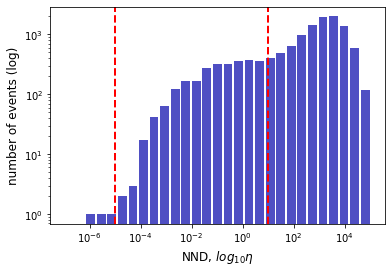

In [20]:
import matplotlib.pyplot as plt

bins = np.logspace(-7,5,30)
plt.xscale('log')
plt.hist(nnd, bins, color='#0504aa', alpha=0.7, rwidth=0.85)
plt.yscale('log')
plt.axvline(x = 10**-5, linewidth = 2, linestyle ="--",
            color ='red')
plt.axvline(x = 10, linewidth = 2, linestyle ="--",
            color ='red')
plt.xlabel('NND, $log_{10}\eta$', fontsize = 12)
plt.ylabel("number of events (log)", fontsize = 12)
plt.show()

# Declustering Algorithm

1. look at scipy tree
2. write a recursive function to find children (depth first tree traversal)
3. embed in a loop over k to get a spanning forest


4. " This bimodality has been documented in multiple regions and on multiple scales (Gentili et al., 2017, 2019; Gu et al., 2013; Kossobokov & Nekrasova, 2017; Moradpour et al., 2014; Peresan & Gentili, 2018; Ruhl et al., 2016; Schoenball et al., 2015; Trugman et al., 2017; Vasylkivska & Huerta, 2017; Zaliapin & Ben-Zion, 2013a, 2013b, 2016a, 2016b). " look at these papers -- anything global?

5. look at zaliapin-zion global paper -- A Global Identification and characterization 
6. try breaking the clusters between by breaking at eta_0 = 10 ** -5

## Recursive function to find children

In [21]:
def children(nnd,nnd_ind, k,eta0,verbose=0):
    if verbose>1: print(f'Looking for children of event {k}:')
        
    # i = nnd_ind[j] means that event i is the parent of event j
    # the values in nnd_ind tells us the parent of event j
    # the values in nnd tell us the distance between event j and its parent
    
    # Find all children
    c = np.where(k == nnd_ind)[0]
    c = c[c!=0] # because event 0 is the parent of event 0
    
    # Limit to children that are close (eta < eta0)
    nearest_neighbor_distances_of_the_children = nnd[c]
    threshold = np.where(nearest_neighbor_distances_of_the_children < eta0)
    if verbose>1: print(f'Found {len(c)} potential children, and '+\
                      f'{len(c[threshold])} are close enough.')
    c = c[threshold]
    c = list(c)
    
    if len(c) == 0:
        if verbose>1: print('\tNo children')
        return []
    else:
        if verbose>0: print(f'\tFound {len(c)} children of {k}: {c}')
        new_c = []
        for i,x in enumerate(c):
            if verbose>1: print(f'\tLooking for grandchildren of {k} that are children of {x} '\
                              f'({i+1} out of {len(c)}):')
            grandchildren = children(nnd, nnd_ind, x,eta0,verbose=verbose)
            for gc in grandchildren:
                new_c.append(gc)

        # Don't modify c until we're outside of the loop
        for nc in new_c:
            c.append(nc)
            
    return c

- The full catalog has no clustering rules

- Using eta0 = 10**5 results in very loose clustering rules (very few related events), while using eta0 = 10 results in moderate clustering rules (moderate number of related earthquakes)

- We conduct ETAS declustering to analyze our results with very strict clustering rules.

In [58]:
from time import perf_counter
t0 = perf_counter()

n_clusters = 0
n_singlets = 0
clusters = []
singlets = [] # catalog of unclustered events
# an event can only be considered a children event if nearest-neigbor distance is < eta0

# eta0 = 10
eta0 = 10**3
nnd_ind_new = nnd_ind
spanning_forest = []
events_in_spanning_forest = []
verbose = 0

# while True:
    
for i in range(len(nnd)):
# for i in range(1000):
    
   # if len(nnd_ind_new) < 2: 
        # if verbose>0: print('All done')
      #  break
   # i = np.min(nnd_ind_new)
    
#     print(np.array(spanning_forest).flatten())
#     print(i)
#     print(' ')
#     print(f'{i} is in {events_in_spanning_forest}?  {np.isin(i,events_in_spanning_forest)}')
    if np.isin(i,events_in_spanning_forest):
        continue
    
    this_tree = children(nnd, nnd_ind, i,eta0,verbose=verbose)
    this_tree.append(i)
    for j in this_tree:
        events_in_spanning_forest.append(j)
    
    spanning_forest.append(this_tree)
    if len(this_tree)>1:
        if verbose>0: print(f'Cluster {n_clusters} has {len(this_tree)} events.')
        print(this_tree)
        clusters.append(np.array(this_tree))
        n_clusters = n_clusters + 1
    
    else:
        singlets.append(np.array(this_tree))
        n_singlets = n_singlets + 1
    
#     if len(this_tree)=1:
#         singlets.append(np.array(this_tree))
#         n_clusters = n_clusters + 1
    '''
    What is the biggest magnitude event in the list of events, this_tree?
    '''
   # We want to remove this_tree from nnd_ind_new 
   # nnd_ind_new = np.setdiff1d(nnd_ind_new, this_tree, assume_unique=True) # is this the issue? indexing?
    
   # if verbose>1: print(f'There are {len(nnd_ind_new)} events remaining.\n')


print(' ')
print(f'Runtime is {perf_counter()-t0}')
print(f'Number of clusters is {n_clusters}.')

[3, 2]
[5, 4]
[7, 8, 9, 6]
[11, 363, 10]
[14, 12]
[18, 13]
[16, 15]
[24, 28, 112, 155, 157, 159, 207, 3579, 240, 256, 354, 355, 364, 451, 455, 457, 23]
[27, 148, 26]
[33, 31]
[37, 34]
[38, 39, 52, 55, 40, 873, 881, 36]
[50, 79, 56, 85, 87, 89, 181, 46]
[49, 48]
[67, 57]
[60, 61, 62, 58]
[68, 380, 385, 386, 59]
[280, 876, 350, 458, 351, 1702, 1703, 2063, 6249, 64]
[72, 73, 75, 74, 77, 78, 76, 1460, 69]
[98, 81]
[109, 83]
[90, 88]
[93, 94, 92]
[97, 101, 95]
[719, 96]
[1313, 1362, 1364, 99]
[104, 162, 169, 186, 187, 102]
[106, 105]
[113, 108]
[115, 114]
[119, 118]
[121, 123, 122, 120]
[125, 326, 124]
[127, 128, 126]
[132, 413, 421, 129]
[141, 131]
[136, 135]
[139, 138]
[448, 489, 499, 140]
[144, 145, 816, 818, 822, 840, 4925, 10475, 10484, 10618, 10676, 11997, 12013, 12051, 12144, 12145, 12146, 12293, 12165, 12166, 12168, 12169, 12303, 12395, 12305, 12309, 12396, 12399, 8243, 8244, 8334, 8335, 8382, 8387, 8396, 143]
[1921, 150]
[152, 211, 151]
[161, 190, 154]
[164, 165, 158]
[171, 167]
[3

[2367, 2371, 2369, 2372, 2373, 2366]
[2375, 2374]
[2390, 2381]
[2384, 2382]
[2414, 2385]
[2388, 2386]
[2393, 2987, 2387]
[2391, 2389]
[2396, 2397, 2395]
[2555, 2404]
[2420, 2410]
[2413, 2411]
[2425, 2417]
[2452, 2454, 2456, 2438]
[2451, 2478, 2479, 2480, 2481, 2482, 2490, 2483, 2510, 2515, 2516, 2519, 2520, 2521, 2522, 2523, 2524, 2525, 2527, 2526, 2533, 2534, 2491, 2492, 2493, 2443]
[2446, 2462, 2463, 2464, 2466, 2508, 2445]
[2501, 2449]
[2547, 2558, 4463, 4480, 4486, 2450]
[2459, 2458]
[2655, 2474]
[2485, 2484]
[2488, 2486]
[2505, 2506, 2489]
[2496, 2494]
[2498, 2509, 2513, 2497]
[2585, 2586, 2588, 2660, 4103, 4151, 2500]
[2770, 2503]
[2529, 2530, 2531, 2528]
[2630, 2536]
[2538, 2539, 2537]
[2541, 2540]
[2634, 2543]
[2546, 2545]
[2549, 2548]
[2553, 2552]
[2557, 2556]
[2562, 2561]
[2653, 2565]
[2576, 2578, 2590, 2579, 2589, 2591, 2600, 2592, 2596, 2605, 2601, 2607, 2608, 2609, 2567]
[2571, 2572, 2574, 2573, 2827, 2568]
[2570, 2610, 2569]
[2583, 2584, 2582]
[2595, 2594]
[2615, 2603]
[2

[4580, 4579]
[4583, 4582]
[4592, 4721, 4591]
[4597, 4614, 4596]
[4599, 4600, 4604, 4598]
[4620, 4946, 10190, 4625, 4947, 4601]
[4627, 4628, 4602]
[4607, 4970, 4995, 5001, 5121, 4603]
[4616, 4622, 4615]
[4689, 4617]
[4621, 4619]
[4630, 4635, 4646, 4660, 4631, 4944, 4962, 4647, 4648, 4667, 4629]
[4634, 4633]
[4640, 4641, 4642, 4643, 4639]
[4651, 4652, 7941, 7946, 4650]
[4664, 4665, 4654]
[4657, 4656]
[4718, 4740, 4666]
[4676, 4677, 4678, 4668]
[4682, 4681]
[4693, 4697, 4684]
[4686, 4685]
[7011, 7019, 7023, 10446, 7026, 7031, 7032, 7033, 7034, 7120, 7035, 7036, 7037, 7038, 7636, 7637, 7639, 7762, 7776, 8085, 8088, 8092, 8093, 8094, 8095, 8096, 8098, 8099, 4703]
[4706, 4720, 4707, 4705]
[4911, 4709]
[4712, 4717, 4725, 4711]
[4714, 4715, 4713]
[4785, 4903, 5389, 6741, 5390, 5391, 5413, 4716]
[4827, 4724]
[4930, 4729]
[4733, 4732]
[4738, 4735]
[4752, 4737]
[4745, 4746, 4749, 4747, 4748, 4744]
[4753, 4755, 4750]
[4759, 4760, 4758]
[4765, 4766, 4767, 4770, 4771, 4772, 4773, 4775, 4764]
[4769, 

[7005, 7006, 6997]
[7001, 7000]
[7009, 7010, 7041, 7007]
[7018, 7016]
[7021, 7022, 7020]
[7047, 7048, 7050, 7053, 7024]
[7028, 7027]
[7061, 7055]
[7057, 7059, 7078, 7161, 7081, 7162, 7176, 7182, 7186, 7214, 7187, 7231, 7241, 7242, 7243, 7247, 7248, 7253, 7254, 7271, 7277, 7278, 7286, 7288, 7289, 7291, 7292, 7296, 7272, 7056]
[7063, 7064, 7062]
[7073, 7079, 7113, 7123, 7124, 7125, 7141, 7126, 7736, 7085, 7197, 7198, 7199, 7200, 7274, 7282, 7357, 7072]
[7690, 8110, 7692, 8111, 7077]
[7084, 7082]
[7101, 7087]
[7217, 7091]
[7103, 7102]
[7106, 7116, 7132, 7105]
[7119, 7110]
[7112, 7121, 7191, 7192, 7193, 7111]
[7134, 7118]
[9448, 7128]
[7131, 7130]
[7136, 7137, 7138, 7139, 7133]
[7584, 7142]
[7147, 7146]
[7400, 7148]
[7150, 7149]
[8392, 8393, 8417, 7151]
[7153, 7152]
[7157, 7195, 7158, 7156]
[7160, 7165, 7257, 7258, 7259, 7260, 7261, 7262, 7279, 7263, 7265, 7280, 7281, 7283, 7287, 7297, 7285, 7302, 7317, 7319, 7321, 7333, 7338, 7339, 7340, 7343, 7341, 7342, 10306, 7344, 7322, 7324, 7328, 73

[8854, 8952, 9151, 9003, 9004, 9011, 9005, 9006, 9061, 9454, 9455, 9472, 9456, 9458, 9457, 8847]
[8924, 8927, 8933, 8850]
[8853, 8881, 8900, 8883, 8886, 8884, 8887, 8901, 8907, 8947, 8953, 8954, 8956, 8955, 8959, 8977, 8962, 8963, 8968, 8972, 8973, 8974, 8975, 9064, 9065, 8978, 8981, 8979, 8987, 8980, 8986, 8993, 8988, 8989, 8990, 8991, 8982, 8984, 8983, 8985, 8852]
[8869, 8870, 8882, 8908, 8948, 8949, 8888, 8868]
[8877, 8878, 8875]
[8919, 8920, 8921, 8876]
[8893, 8905, 9017, 8915, 8892]
[8895, 8896, 8894]
[8928, 8929, 8934, 8935, 8936, 8938, 8939, 8941, 8943, 8940, 8942, 8944, 8945, 8897]
[8925, 8926, 8902]
[8904, 8903]
[8912, 8911]
[8917, 8916]
[10214, 8923]
[9026, 8930]
[8966, 8965]
[9000, 9007, 8967]
[8971, 8970]
[8994, 8992]
[9711, 8996]
[9338, 8997]
[9072, 9095, 9096, 9008]
[9040, 9728, 9041, 9046, 9056, 9156, 9157, 9162, 9167, 9009]
[9018, 9016]
[9021, 9020]
[9083, 9027]
[9113, 9118, 9028]
[9034, 9037, 9038, 9039, 9048, 9042, 9043, 9045, 9047, 9052, 9049, 9050, 9055, 9051, 9053,

[11270, 10389]
[10391, 10390]
[10394, 10393]
[10402, 10423, 10512, 10427, 10430, 10401]
[10433, 10434, 10404]
[10407, 10751, 10406]
[10409, 10408]
[10454, 10412]
[10444, 10429]
[10439, 10435]
[10447, 10485, 11074, 11075, 11153, 10437]
[10441, 10442, 10452, 10440]
[10457, 11516, 10458, 10456]
[10630, 10631, 12533, 10467]
[10487, 10486]
[10489, 10488]
[10493, 10492]
[10510, 10498]
[10500, 10499]
[10509, 10508]
[10668, 10514]
[10519, 10605, 10518]
[10528, 10534, 10536, 10553, 10675, 10520]
[10522, 10529, 10533, 10524, 10554, 10563, 10555, 10559, 10541, 10542, 10543, 10544, 10545, 10546, 10547, 10548, 10549, 10573, 10574, 10639, 10640, 10643, 10521]
[10610, 10532]
[10557, 11224, 10558, 10632, 10556]
[10571, 10572, 10606, 10607, 10946, 10608, 10570]
[10633, 10593]
[10601, 10602, 10600]
[10604, 10603]
[11024, 10613]
[10768, 10934, 11375, 10959, 10966, 10967, 10972, 11263, 11264, 11930, 10623]
[10627, 10624]
[10628, 10629, 10626]
[10637, 10636]
[10646, 10661, 10645]
[10653, 10789, 10799, 1080

In [59]:
# Finding first event in each cluster

first_event_in_cluster = []
n = len(clusters)

for i in range(n):
    first_event_in_cluster.append(np.min(clusters[i]))

# converting list of arrays to array

first_event_in_cluster = np.concatenate(first_event_in_cluster, axis=None)
singlets = np.concatenate(singlets, axis=None)

In [60]:
moderate_clustered_catalog = set( np.sort (np.concatenate ((first_event_in_cluster,singlets)) ) )

In [61]:
print(f'The full catalog contains {len(catalog)} events.')

print(f'The catalog declustered using Zaliapin & Ben-Zions Nearest Neighbor method contains {len(moderate_clustered_catalog)} events.')

print(f'The catalog declustered using Mizrahis ETAS model contains 537 events.')

The full catalog contains 12573 events.
The catalog declustered using Zaliapin & Ben-Zions Nearest Neighbor method contains 5711 events.
The catalog declustered using Mizrahis ETAS model contains 537 events.


In [41]:
# Saving list of events in moderately clustered catalog to csv

# pd.DataFrame(moderate_clustered_catalog).to_csv("NND_declustered_catalog.csv") # uses eta=10
pd.DataFrame(moderate_clustered_catalog).to_csv("NND_declustered_catalog_v2.csv") # uses eta=10**3